In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import json
import pandas as pd

In [2]:
# Plotting Helpers

from __future__ import division, print_function, absolute_import

import numpy as np
from matplotlib.colors import ColorConverter
from matplotlib import rcParams


__author__ = 'Felix Berkenkamp / Johannes Kirschner'
__all__ = ['set_figure_params', 'emulate_color', 'linewidth_in_data_units',
           'adapt_figure_size_from_axes', 'cm2inches', 'hide_all_ticks',
           'hide_spines', 'set_frame_properties']


def emulate_color(color, alpha=1, background_color=(1, 1, 1)):
    """Take an RGBA color and an RGB background, return the emulated RGB color.
    The RGBA color with transparency alpha is converted to an RGB color via
    emulation in front of the background_color.
    """
    to_rgb = ColorConverter().to_rgb
    color = to_rgb(color)
    background_color = to_rgb(background_color)
    return [(1 - alpha) * bg_col + alpha * col
            for col, bg_col in zip(color, background_color)]


def cm2inches(centimeters):
    """Convert cm to inches"""
    return centimeters / 2.54


def set_figure_params(serif=True):
    """Define default values for font, fontsize and use latex
    Parameters
    ----------
    serif: bool, optional
        Whether to use a serif or sans-serif font
    """

    params = {
              'font.family': 'serif',
              'font.serif': ['Times',
                             'Palatino',
                             'New Century Schoolbook',
                             'Bookman',
                             'Computer Modern Roman'],
              'font.sans-serif': ['Times',
                                  'Helvetica',
                                  'Avant Garde',
                                  'Computer Modern Sans serif'],
              'text.usetex': True,
              # Make sure mathcal doesn't use the Times style
              'text.latex.preamble':
              r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}',

              'axes.labelsize': 9,
              'axes.linewidth': .75,

              'font.size': 9,
              'legend.fontsize': 9,
              'xtick.labelsize': 9,
              'ytick.labelsize': 9,

              # 'figure.dpi': 150,
              # 'savefig.dpi': 600,
              # 'legend.numpoints': 1,
              }

    if not serif:
        params['font.family'] = 'sans-serif'

    rcParams.update(params)


def hide_all_ticks(axis):
    """Hide all ticks on the axis.
    Parameters
    ----------
    axis: matplotlib axis
    """
    axis.tick_params(axis='both',        # changes apply to the x-axis
                     which='both',       # affect both major and minor ticks
                     bottom='off',       # ticks along the bottom edge are off
                     top='off',          # ticks along the top edge are off
                     left='off',         # No ticks left
                     right='off',        # No ticks right
                     labelbottom='off',  # No tick-label at bottom
                     labelleft='off')    # No tick-label at bottom


def hide_spines(*axes, top=True, right=True):
    
    for axis in axes:
        """Hide the top and right spine of the axis."""
        if top:
            axis.spines['top'].set_visible(False)
            axis.xaxis.set_ticks_position('bottom')
        if right:
            axis.spines['right'].set_visible(False)
            axis.yaxis.set_ticks_position('left')


def set_frame_properties(axis, color, lw):
    """Set color and linewidth of frame."""
    for spine in axis.spines.values():
        spine.set_linewidth(lw)
        spine.set_color(color)


def linewidth_in_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.
    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.
    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()

    if reference == 'x':
        # width of the axis in inches
        axis_length = fig.get_figwidth() * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        axis_length = fig.get_figheight() * axis.get_position().height
        value_range = np.diff(axis.get_ylim())

    # Convert axis_length from inches to points
    axis_length *= 72

    return (linewidth / value_range) * axis_length


def adapt_figure_size_from_axes(axes):
    """
    Adapt the figure sizes so that all axes are equally wide/high.
    When putting multiple figures next to each other in Latex, some
    figures will have axis labels, while others do not. As a result,
    having the same figure width for all figures looks really strange.
    This script adapts the figure sizes post-plotting, so that all the axes
    have the same width and height.
    Be sure to call plt.tight_layout() again after this operation!
    This doesn't work if you have multiple axis on one figure and want them
    all to scale proportionally, but should be an easy extension.
    Parameters
    ----------
    axes: list
        List of axes that we want to have the same size (need to be
        on different figures)
    """
    # Get parent figures
    figures = [axis.get_figure() for axis in axes]

    # get axis sizes [0, 1] and figure sizes [inches]
    axis_sizes = np.array([axis.get_position().size for axis in axes])
    figure_sizes = np.array([figure.get_size_inches() for figure in figures])

    # Compute average axis size [inches]
    avg_axis_size = np.average(axis_sizes * figure_sizes, axis=0)

    # New figure size is the average axis size plus the white space that is
    # not begin used by the axis so far (e.g., the space used by labels)
    new_figure_sizes = (1 - axis_sizes) * figure_sizes + avg_axis_size

    # Set new figure sizes
    for figure, size in zip(figures, new_figure_sizes):
        figure.set_size_inches(size)
        
def plot_errorbars(axis, x, y, err, num=10, sigma=2, **kwargs):
    T = len(y)
    axis.errorbar(x[T//(2*num):], y[T//(2*num):], sigma*err[T//(2*num):], 
                  ecolor=emulate_color('black', alpha=0.6),
                     capsize=2,
                     capthick=0.3,
                     elinewidth=0.3,
                     linewidth=0.6,
                     fmt="none",
                     errorevery=T//num,
                     **kwargs)

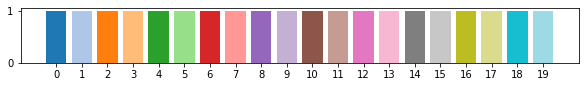

In [3]:
# define tableau colors:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
(188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.figure(figsize=(10,1))
for i,c in enumerate(tableau20):
    plt.bar(i,1, color=c)

    
plt.xticks([*range(20)])
plt.show()
set_figure_params()

In [4]:
def load_data(env_path, basedir):
    """ helper function to load aggregated data """
    data = dict()
    
    for path in glob.iglob(os.path.join(basedir, env_path, '*/'), recursive=False):
        strategy = path.rsplit(os.sep, maxsplit=3)[2]
        env = path.rsplit(os.sep, maxsplit=3)[1]
        env, horizon = env.split('-')
        horizon = int(horizon)
        
#         print(env, strategy)

        strategy_dict = dict()
        
        
        # get all files that were created for regret aggregation, there might be multiple
        aggr_files = [os.path.split(f)[1] for f in glob.iglob(path + 'aggr-*.csv')]
        print(aggr_files)
        
            
        
        if len(aggr_files) == 0:
            continue
            
        with open(os.path.join(path, 'params.json')) as json_file:
            args = json.load(json_file)
        
        name = strategy.split('-')[0]
        strategy_dict['args'] = args
        strategy_dict['algorithm'] = name
        strategy_dict['env'] = env
        strategy_dict['n'] = horizon
        args_str = ','.join(f"{k}={v}" for k,v in args.items())
        strategy_dict['algorithm_args'] = f"{name}-{args_str}"
                                                        
        # find different aggregators and use the largest one
        aggr_dict = {}
        count = 0
        for file in aggr_files:
            _, aggr, count = file.split('-')
            count = int(count[:-4])  # shave of '.csv' suffix
            if aggr_dict.get(aggr, (0, None))[0] < count:
                aggr_dict[aggr] = count, file
                        
        for aggr, (count, file) in aggr_dict.items():
            # store data
            print(f"{name}: reading {file} with {count} runs.")
            strategy_dict[aggr] = pd.read_csv(os.path.join(path, file), delimiter=" ", header=None).values

#             strategy_dict[aggr] = np.loadtxt(os.path.join(path, file))
        strategy_dict['repetitions'] = count
        
        data[strategy] = strategy_dict
        
    data = {k : v for k,v in sorted(data.items(), key=lambda i: i[1]['algorithm_args']) }
    return env, data

In [120]:
def plot_regret(data, axis, exclude=None, color_fct=None, label_fct=None, line_fct=None):
    
    color_idx = 0
    for strategy, strategy_data in data.items():
        if exclude is not None and exclude(strategy_data):
            continue

        regret = strategy_data['regret']
        n = strategy_data['n']
        x=np.arange(n)
        rep = strategy_data['repetitions']
        
        # get label
        label = None
        if label_fct is not None:
            label = label_fct(strategy_data)
        if label is None:
            label = strategy
            
        # get color
        color = None
        if color_fct is not None:
            color = color_fct(strategy_data)
        if color is None:
            color = tableau20[color_idx]
            color_idx += 1
            
        line = None
        if line_fct is not None:
            line = line_fct(strategy_data)
        if line is None:
            line = '-'
        
        axis.plot(x, regret[:n, 0], label=label, color=color, linewidth=1, linestyle=line)
        plot_errorbars(axis, x, regret[:n, 0], regret[:n, 1]/np.sqrt(rep), num=10, sigma=2)
        plt.ylabel('Regret')
        
#         axis.errorbar(np.arange(n), regret[:, 1]/np.sqrt(strategy_data['repetitions']))

In [121]:
# DEFINITIONS

TEXTWIDTH = 15.23782  # width from latex paper

# Not used right now / keep for later
# # labels and colors
# LABELS = {
#     'ids-full' : 'IDS',
#     'ucb' : 'UCB',
#     'ucb-s2' : 'UCB-log(s2)',
#     'ids-directed2' :'IDS-direct',
#     'asymptotic_ids' : 'Asymptotic IDS',
#     'asymptotic_ids++' : 'Asymptotic IDS++',
#     'Solid': 'Solid'

# }
# COLORS = {
#     'ids-full' : tableau20[0],
#     'ucb' : tableau20[2],
#     'ucb-s2' : tableau20[3],
#     'ids-directed2' : tableau20[4],
#     'ids-info_game' : tableau20[6],
#     'asymptotic_ids-1.0' : tableau20[8],
#     'asymptotic_ids-0.01' : tableau20[9],
#     'asymptotic_ids-0.001' : tableau20[10],
#     'asymptotic_ids-1.0++' : tableau20[12],
#     'asymptotic_ids-0.01++' : tableau20[12],
#     'Solid' : tableau20[16]
# }

In [152]:
# simple_bandit = load_regret_data('counter_example_0.01-10000')
# env, data = load_data('simple_bandit_3-500000', basedir='../runs-colt2021')
# env, data = load_data('simple_bandit_3-2000000', basedir='../runs-colt2021')

# env, data = load_data('simple_bandit-500000', basedir='../runs-colt2021')
# env, data = load_data('simple_bandit-300000', basedir='../runs-colt2021')

# env, data = load_data('counter_example_0.02-1000000', basedir='../runs-colt2021')
# env, data = load_data('counter_example_0.05-200000', basedir='../runs-colt2021')
# env, data = load_data('counter_example_0.001-2500000', basedir='../runs-colt2021-aggr')
# env, data = load_data('counter_example_0.05-2500000', basedir='../runs-colt2021-aggr')
# env, data = load_data('counter_example_0.03-2500000', basedir='../runs-colt2021-aggr')
# env, data = load_data('counter_example_0.01-2500000', basedir='../runs-colt2021-aggr')
# env, data = load_data('counter_example_0.08-2500000', basedir='../runs-colt2021-aggr')
# env, data = load_data('counter_example_v0.1_e0.01_a0.5-2500000', basedir='../runs-colt2021-aggr')
# env, data = load_data('counter_example_v0.1_e0.05_a0.5-2500000', basedir='../runs-colt2021-aggr')
# env, data = load_data('counter_example_v0.1_e0.05_a1.0-2500000', basedir='../runs-colt2021-aggr')
# exp_name = 'counter_example_v0.1_e0.01_a0.5-1000000'
# exp_name = 'large_gaps_v0.1-1000000'
exp_name = 'simple_bandit_v0.1-1000000'
env, data = load_data(exp_name, basedir='../runs-example')
# env, data = load_data('large_gaps_v0.1-1000000', basedir='../pm-runs')
# lb = pd.read_csv('../runs-example/'+exp_name+'/lb/lb.csv', delimiter=" ", header=None).values
# env, data = load_data('large_gaps-1000000', basedir='../runs-colt2021-aggr')

[*data.keys()]

['aggr-regret-100.csv']
TS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-61.csv']
Solid: reading aggr-regret-61.csv with 61 runs.
['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
TS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
UCB: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
Solid: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-60.csv']
Solid: reading aggr-regret-60.csv with 60 runs.
['aggr-regret-100.csv']
Solid: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.


['AsymptoticIDS-e54d082864730fbc264da2db06f6a6df',
 'AsymptoticIDS-f1f80f7a873bca5d3758b943e4071294',
 'AsymptoticIDS-b2c5dc9ff796e860e40d581560e275e9',
 'AsymptoticIDS-857765119c7ccebb52b414a90ba7873d',
 'Solid-b4c819c34b43326a23b2b462887a8851',
 'Solid-1d405251592737ce6dada92987a899a8',
 'Solid-96ce9b816f22d58656c22c3225405c8f',
 'Solid-324d4c4dd0978478d40625aae3ef8a5f',
 'TS-0f0c2f109d809884631df789f6af7887',
 'TS-3e4409410c9a616844af0fe71b9207f9',
 'UCB-c8e0d8c0efa2aee6b40ba0e261d53fe9']

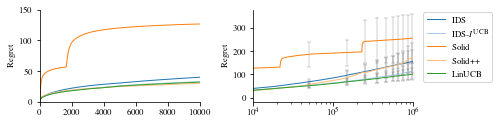

In [153]:
only_logdet = True

def exclude_fct(strategy_data):
    """ exclude specific runs from plotting """
    args = strategy_data['args']
#     if strategy_data['repetitions'] != 100:
#         return False
    if strategy_data['algorithm'] == 'TS':
        return True
    
#     # include only logdet results
#     if only_logdet:
#         if not args['beta_logdet']:
#             return True
#     else:
#          # include only asymptotic coefficent results
#         if args['beta_logdet']:
#             return True
        
    
    if args.get('solid_z0')==100:
        return True

            

#     if args.get('solid_z0')== False:
#         return False
        
#     if strategy_data['algorithm'] == 'AsymptoticIDS':
#         if not args['ids_fast_info']:
#             return False
    
    
    
    return False


def label_fct(strategy_data):
    """ read data for strategy and return a label. By default, returns the algorithm name. """
    label = strategy_data['algorithm']
    args = strategy_data['args']
    if label == 'AsymptoticIDS':
        if args.get('ids_fast_info'):
            label = 'IDS'#'Fast' + label
        else:
            label = 'IDS-Cell'
        if args.get('opt2'):
            label += r'-$I^{\textsc{ucb}}$'
#         label += f",alpha={args.get('alpha')}"
#         label += f",ucb={args.get('ucb_switch')}"
#     if label == 'Solid':
#         if not args.get('solid_reset'):
#             label += '++'
    if label == 'Solid':
        if not args.get('solid_reset'):
            label += '++'
#         if args.get('solid_opt'):
#             label += '(opt)'
#         if args.get('solid_z0'):
#             label += f"z0={args.get('solid_z0')}"
       
#     if args['beta_logdet']:
#         label += "(logdet)"
#     else:
#         label += "(loglog)"
    if label == 'UCB':
        label = 'LinUCB'

    
    return label

def line_fct(strategy_data):
    """ defines the linestyle """
    args = strategy_data['args']
    # include only logdet results
    if not args['beta_logdet']:
        return '-.'
    
    return '-'
    


fig, axis = plt.subplots(ncols=2)


# some generic figure improvements
# set_figure_params()
hide_spines(*axis)

# plot first axis
plot_regret(data, axis[0], exclude=exclude_fct, label_fct=label_fct, line_fct=line_fct)
axis[0].set_ylabel('Regret')
# axis[0].legend()
# axis[0].ticklabel_format(axis='x', style='sci', scilimits=None, useOffset=None, useLocale=None, useMathText=None)

axis[0].set_xlim((0.,10000))
axis[0].set_ylim((0, 150))
# second axis
plot_regret(data, axis[1], exclude=exclude_fct, label_fct=label_fct, line_fct=line_fct)
# axis[1].legend()

# axis[1].plot(lb, label='lb', color='k')
axis[1].set_xscale('log')
axis[1].set_xlim((10000,1000000))
handles, labels = axis[-1].get_legend_handles_labels()

# box = fig.get_position()
# axis[1].set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])
# axis[0].set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# # Put a legend below current axis
# fig.legend(handles, label, loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)


lgd = fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 0.9))
# figure size is set to JMLR paper width
fig.set_size_inches(cm2inches(TEXTWIDTH),1.8)


fig.subplots_adjust()
fig.tight_layout()

fig.savefig(os.path.join('../plots/', f'{env}.pdf',), bbox_inches='tight', pad_inches=0.1)


<ipython-input-61-b17ef131081f>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [137]:
data.items()


dict_items([('AsymptoticIDS-0e8b0a861831c52a0370c9de2b49623f', {'args': {'alpha': 1.0, 'beta_logdet': True, 'dids': False, 'eoo_alpha': 1.0, 'eoo_eps': 0.01, 'fast_ratio': False, 'game': 'large_gaps', 'ids_fast_info': False, 'laser_indirect': False, 'lb_return': False, 'lls_scale_obs': False, 'lower_bound_gaps': False, 'n': 1000000, 'noise_var': 0.1, 'opt2': False, 'solid_opt': False, 'solid_reset': False, 'solid_z0': 100, 'strategy': 'asymptotic_ids', 'ts_scale': 1.0, 'ucb_switch': False}, 'algorithm': 'AsymptoticIDS', 'env': 'large_gaps_v0.1', 'n': 1000000, 'algorithm_args': 'AsymptoticIDS-alpha=1.0,beta_logdet=True,dids=False,eoo_alpha=1.0,eoo_eps=0.01,fast_ratio=False,game=large_gaps,ids_fast_info=False,laser_indirect=False,lb_return=False,lls_scale_obs=False,lower_bound_gaps=False,n=1000000,noise_var=0.1,opt2=False,solid_opt=False,solid_reset=False,solid_z0=100,strategy=asymptotic_ids,ts_scale=1.0,ucb_switch=False', 'regret': array([[ 0.        ,  0.        ],
       [ 0.        ,